# **Spam Mail Detection Using Machine Learning**

pam mail detection using machine learning is a classic and practical application of natural language processing and text classification techniques. The goal is to build a model that can automatically identify and classify emails as either "spam" (unwanted or unsolicited messages) or "ham" (legitimate or non-spam messages).

In [ ]:
pip install missingno

In [ ]:
pip install lightgbm

In [ ]:
pip install xgboost

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.5 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

# for visualization
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from wordcloud import WordCloud


# nltk used for NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Preprocessing (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay

# styling
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv("spam.csv", encoding='latin1')

In [ ]:
# Suppose you want to drop columns 'Column1', 'Column2', and 'Column3'
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df.drop(columns=columns_to_drop, inplace=True)

Text(0.5, 1.0, 'Distribution of missing values')

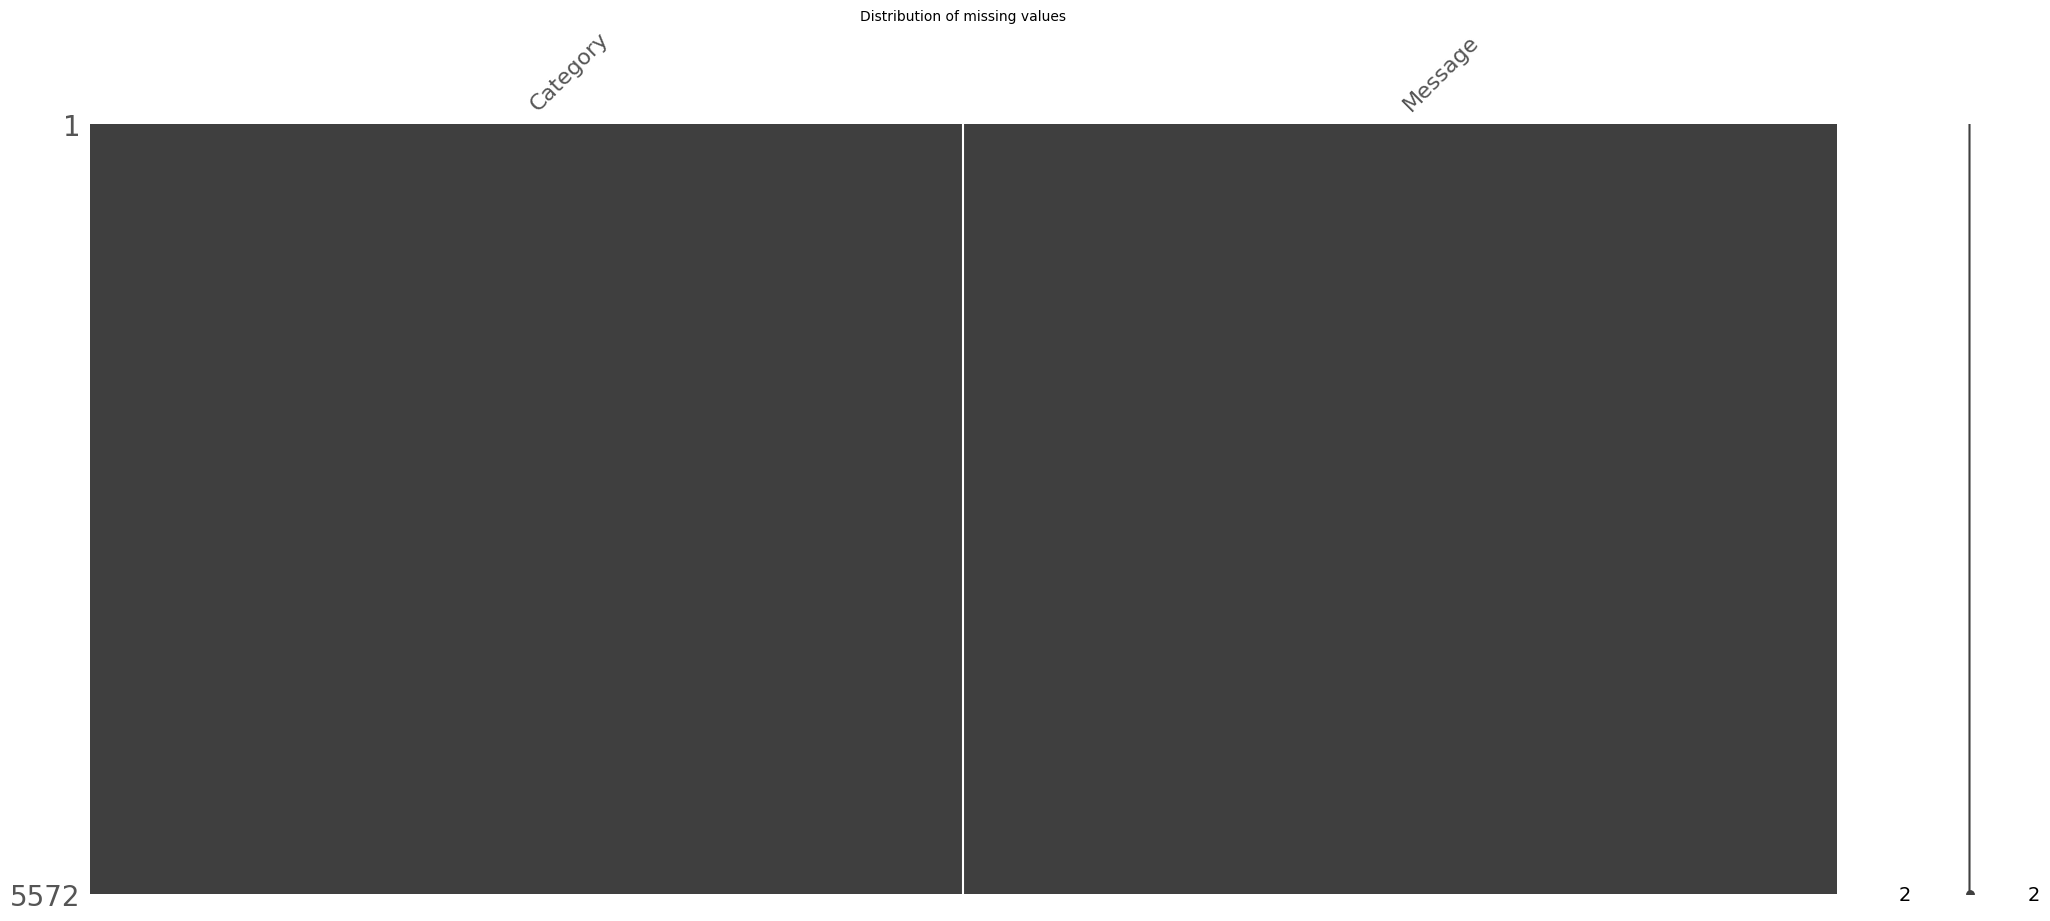

In [ ]:
msno.matrix(df).set_title('Distribution of missing values', fontsize=10)

In [ ]:
print(df.shape)
df.head(3)

(5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


 **Distribution of each category**  

# EDA on features (length added)
**bold text**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
category_ct = df['Category'].value_counts()

fig = px.pie(values=category_ct.values,
             names=category_ct.index,
             color_discrete_sequence=px.colors.sequential.OrRd,
             title= 'Pie Graph: spam or not')
fig.update_traces(hoverinfo='label+percent', textinfo='label+value+percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()

## Length distribution of spam & ham meesage

In [ ]:
categories = pd.get_dummies(df["Category"])
spam_or_not = pd.concat([df, categories], axis=1)
spam_or_not.drop('Category',axis=1,inplace=True)

df["length"] = df["Message"].apply(len)

ham = df.loc[np.where(spam_or_not['ham'] == 1)].reset_index()
spam = df.loc[np.where(spam_or_not['ham'] == 0)].reset_index()

ham.drop('index',axis=1,inplace=True)
spam.drop('index',axis=1,inplace=True)

In [ ]:
hist_data = [ham['length'],spam['length']]

group_labels = ['ham','spam']

colors = ['black', 'red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Length distribution of ham and spam messages',
                 template = 'simple_white')
fig.show()

##  Ham & Spam Message Analysis

In [ ]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['Message'][i]
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text):
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
#     result = result.lower()
#     result = nltk.word_tokenize(text)
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(stopwords, lst):
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist]
    return cleanwordlist

# function to get dataframe from cleanwordlist.
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to lemmatize words
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

In [ ]:
# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= colormap,
               max_font_size=140,
               min_font_size = 2,
               random_state=8888,
               background_color=color_background).generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [ ]:
ham.tail(3)

,Category,Message,length
4822,ham,"Pity, * was in mood for that. So...any other s...",57
4823,ham,The guy did some bitching but I acted like i'd...,125
4824,ham,Rofl. Its true to its name,26


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
string = get_all_str(ham)
words = get_word(string)
removed = remove_stopword('1',words)
# show 10 words for example
print(removed[:10])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la']


In [ ]:
freq_df = Freq_df(removed)
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             title = 'Rank of Ham Terms',
             template = "simple_white"
              )

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

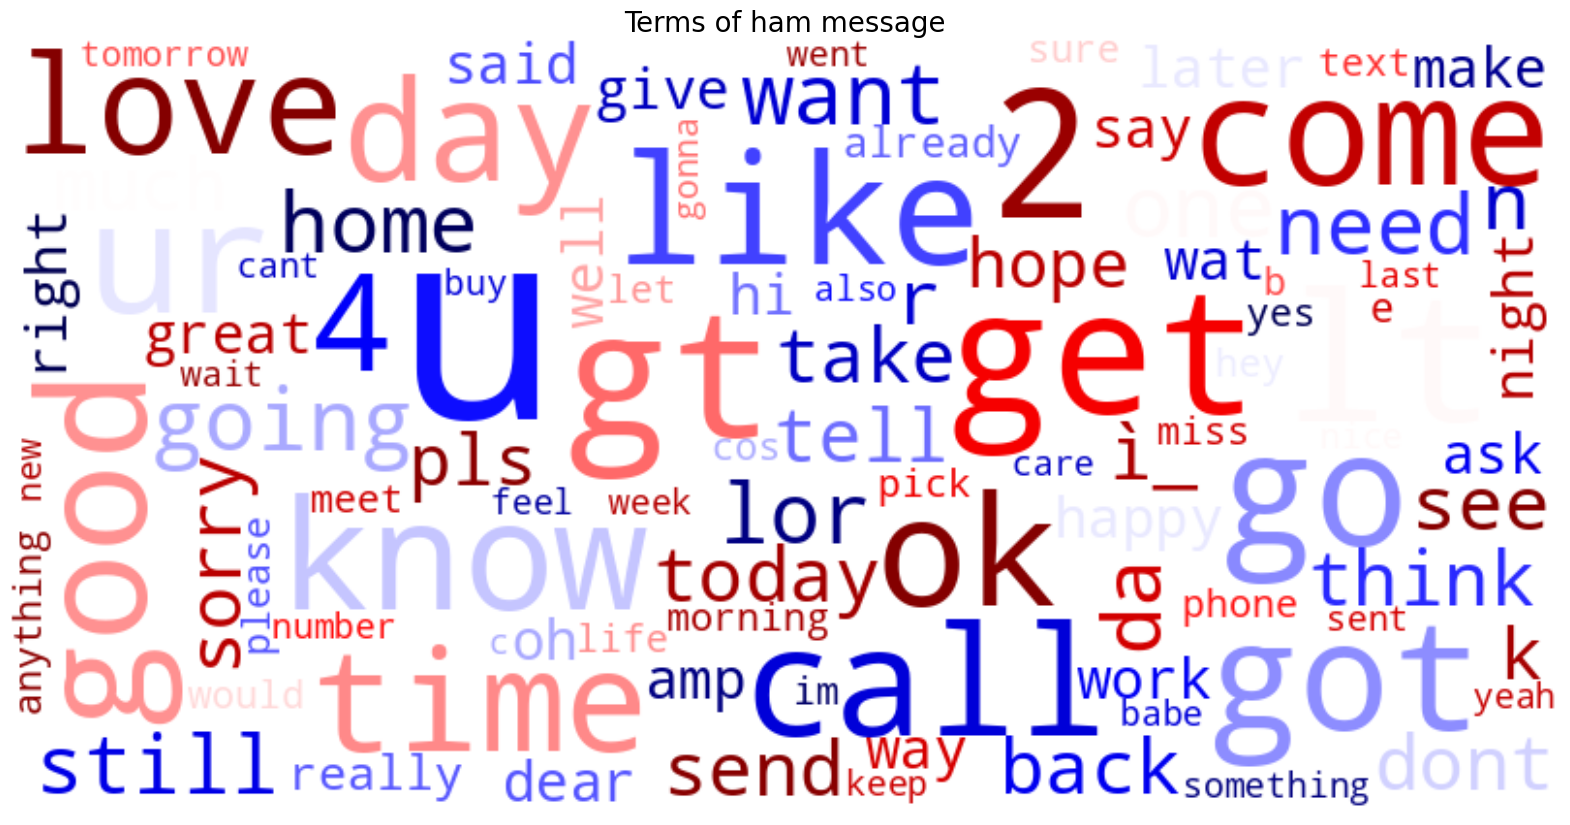

In [ ]:
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

ham_wordcloud = Word_Cloud(data ,'white', 'seismic', 'Terms of ham message')

In [ ]:
string = get_all_str(spam)
words = get_word(string)
removed = remove_stopword('1',words)

In [ ]:
def preprocess(sentence):
    words = get_word(sentence)
    words_ltz = lemmatization(words)
    removed = remove_stopword('1',words_ltz)
    return removed

In [ ]:
df.replace('ham',1,inplace=True)
df.replace('spam',0,inplace=True)

In [ ]:
df.head()

,Category,Message,length
0,1,"Go until jurong point, crazy.. Available only ...",111
1,1,Ok lar... Joking wif u oni...,29
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,1,U dun say so early hor... U c already then say...,49
4,1,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
vector = CountVectorizer(analyzer = preprocess)
X = vector.fit(df['Message'])
X_transform = X.transform(df['Message'])


In [ ]:
tfidf_transformer = TfidfTransformer().fit(X_transform)
X = tfidf_transformer.transform(X_transform)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, df['Category'], test_size=0.30, random_state = 8888)

In [ ]:
rfc=RandomForestClassifier(random_state=8888)
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)
xgbr = xgb.XGBClassifier(objective='binary:hinge',random_state=8888)
svc = SVC(probability=True,random_state=8888)
catboost = CatBoostClassifier(random_state=8888, logging_level='Silent')

rfc.fit(train_X,train_y)
lgbm.fit(train_X, train_y)
xgbr.fit(train_X, train_y)
svc.fit(train_X, train_y)
catboost.fit(train_X,train_y,verbose=0)

classifiers = []
classifiers.append(svc)
classifiers.append(rfc)
classifiers.append(xgbr)
classifiers.append(lgbm)
classifiers.append(catboost)

model_name = ['SVC', 'Random Forest', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

In [ ]:
accuracy_list = []
auc_list=[]
recall_list = []
f1_list = []

for classifier in classifiers :
    y_pred=classifier.predict(test_X)
    y_pred_proba=classifier.predict_proba(test_X)[:,1]
    accuracy_list.append(accuracy_score(test_y,y_pred))
    auc_list.append(roc_auc_score(test_y, y_pred_proba))
    recall_list.append(recall_score(test_y, y_pred))
    f1_list.append(f1_score(test_y, y_pred))

In [ ]:
def plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list, title):

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=model_name, y=np.round(accuracy_list,3), text=np.round(accuracy_list,3), marker_color='#97bad9'),
        go.Bar(name='AUC',x=model_name, y=np.round(auc_list,3), text=np.round(auc_list,3), marker_color= '#bcd6ef'),
        go.Bar(name='Recall',   x=model_name, y=np.round(recall_list,3), text=np.round(recall_list,3), marker_color='#ebcad9'),
        go.Bar(name='F1',       x=model_name, y=np.round(f1_list,3), text=np.round(f1_list,3), marker_color='#d5a6bd')
    ])

    fig.update_layout(template = 'simple_white', title = title)
    fig.update_layout(xaxis_title="Models", yaxis_title="Score", font = dict(size=17, family = 'Franklin Gothic'))
    fig.update_layout(yaxis_range=[0.7,1])

    fig.show()

In [ ]:
plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list,
                 'Accuracy, AUC, Recall Score & F1 Score')

In [ ]:
# set random_state
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=8888)
cv_accuracy_results = []
cv_auc_results = []
cv_recall_results = []
cv_f1_results = []

for classifier in classifiers:
    cv_accuracy_results.append(cross_val_score(classifier, train_X, y = train_y, scoring = "accuracy", cv = kfold))
    cv_auc_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'roc_auc', cv = kfold))
    cv_recall_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'recall', cv = kfold))
    cv_f1_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'f1', cv = kfold))


cv_accuracy_means = []
cv_auc_means = []
cv_recall_means = []
cv_f1_means = []

for fold in range(5):
    cv_accuracy_means.append(cv_accuracy_results[fold].mean())
    cv_auc_means.append(cv_auc_results[fold].mean())
    cv_recall_means.append(cv_recall_results[fold].mean())
    cv_f1_means.append(cv_f1_results[fold].mean())

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means, 'Cross Validation (5 fold)')

In [84]:
votingC = VotingClassifier(estimators=[('light gbm', lgbm),('Random Forest', rfc),
                                       ('Cat boost',catboost)],voting='soft')

votingC = votingC.fit(train_X, train_y)

v_accuracy = cross_val_score(votingC, train_X, y = train_y, scoring = "accuracy", cv = kfold)
v_auc = cross_val_score(votingC, train_X, y = train_y, scoring = "roc_auc", cv = kfold)
v_recall = cross_val_score(votingC, train_X, y = train_y, scoring = "recall", cv = kfold)
v_f1 = cross_val_score(votingC, train_X, y = train_y, scoring = "f1", cv = kfold)

votingC_accuracy_mean = v_accuracy.mean()
votingC_auc_mean = v_auc.mean()
votingC_recall_mean = v_auc.mean()
votingC_f1_mean = v_auc.mean()

model_name.append('Voting Classifier')
cv_accuracy_means.append(votingC_accuracy_mean)
cv_auc_means.append(votingC_auc_mean)
cv_recall_means.append(votingC_recall_mean),
cv_f1_means.append(votingC_f1_mean)

In [85]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (5 fold), Voting Classifier Added')

In [86]:
voting_y_pred = votingC.predict(test_X)
voting_y_pred_proba=votingC.predict_proba(test_X)[:,1]

In [87]:
voting_y_pred

array([1, 0, 1, ..., 1, 1, 0])

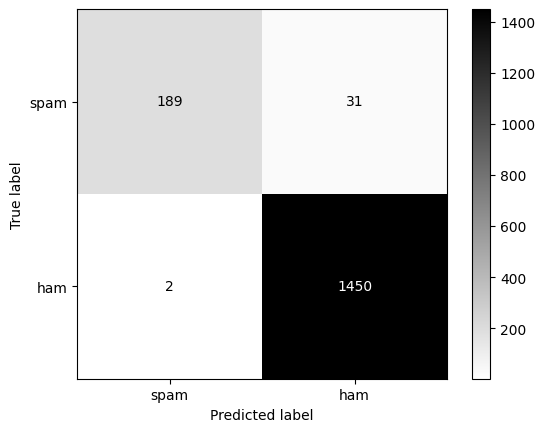

In [88]:
plt.style.use('default')
cm = confusion_matrix(test_y, voting_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['spam','ham'])
disp.plot(cmap='binary')

In [89]:
X = df['Message']
y = df['Category']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state = 8888)
max_len = max(max(train_X.apply(len).values),max(test_X.apply(len).values))

def fit_tokenizer(text, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token)
    tokenizer.fit_on_texts(text)
    return tokenizer

# for sequence, padding
def seq_padding(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen = maxlen, truncating=padding)
    return pad_trunc_sequences

tokenizer = fit_tokenizer(train_X, "<OOV>")

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

train_X = seq_padding(train_X,tokenizer, 'post', 'post',max_len)
test_X = seq_padding(test_X,tokenizer, 'post', 'post', max_len)

def callback(MATRIX, PATIENCE):

    callbacks = [EarlyStopping(monitor=MATRIX,
                                patience=PATIENCE,
                                restore_best_weights=True),
                  ModelCheckpoint('model',
                                  monitor=MATRIX,
                                  save_best_only=True,
                                  save_weights_only=True)]
    return callbacks

def LSTM_model(vocab_size, embedding_dim, maxlen):

    model = Sequential()

    model.add(Embedding(vocab_size+1,embedding_dim,input_length = maxlen))
    model.add(Bidirectional(LSTM(64,kernel_regularizer=keras.regularizers.l2(0.001))))

    tf.keras.layers.GlobalAveragePooling1D()

    model.add(Dense(6, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics = ['Accuracy'])

    return model

model = LSTM_model(VOCAB_SIZE, 100, max_len)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 910, 100)          736400    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 821,661
Trainable params: 821,661
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_X, train_y, epochs = 8, batch_size = 8, callbacks = callback('Accuracy', 2))

test_prediction_label = (model.predict(test_X) >= 0.5).astype("int32")
test_predict_proba = model.predict(test_X, verbose=0)

NN_accuracy = accuracy_score(test_y, test_prediction_label)
NN_AUC = roc_auc_score(test_y, test_prediction_label)
NN_recall = recall_score(test_y, test_prediction_label)
NN_f1 = f1_score(test_y, test_prediction_label)

print(NN_accuracy, NN_AUC, NN_recall, NN_f1)

Epoch 1/8
488/488 [==============================] - 446s 905ms/step - loss: 0.5408 - Accuracy: 0.8741
Epoch 2/8
488/488 [==============================] - 443s 907ms/step - loss: 0.2298 - Accuracy: 0.9703
Epoch 3/8
458/488 [===========================>..] - ETA: 27s - loss: 0.1196 - Accuracy: 0.9855

In [ ]:
cv_accuracy_means.append(NN_accuracy)
cv_auc_means.append(NN_AUC)
cv_recall_means.append(NN_recall),
cv_f1_means.append(NN_f1)
model_name.append('NN')

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (5 fold)')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Convert 'train_X' and 'test_X' to strings if they are numpy.ndarray objects
train_X_str = train_X.astype(str)
test_X_str = test_X.astype(str)

In [ ]:
# Convert text to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train_X_str)
X_test_counts = vectorizer.transform(test_X_str)

In [ ]:
# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_y)
y_test_encoded = label_encoder.transform(test_y)

In [ ]:
# Create the Voting Classifier
voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')

In [ ]:
# Fit the Voting Classifier to the training data
voting_classifier.fit(X_train_counts, y_train_encoded)

In [ ]:
# Predict the labels for the test data
y_pred_encoded = voting_classifier.predict(X_test_counts)

In [ ]:
# Evaluate the performance of the Voting Classifier
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("AUC:", auc)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re

In [ ]:
# Define custom tokenizer with preprocessing steps
def custom_tokenizer(text):
    if isinstance(text, bytes):
        text = text.decode('utf-8')
    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Split text into individual words
    words = text.split()
    return words

In [ ]:
# Convert byte data to string using UTF-8 decoding
train_X_str = np.array([x.decode('utf-8') if isinstance(x, bytes) else x for x in train_X])
test_X_str = np.array([x.decode('utf-8') if isinstance(x, bytes) else x for x in test_X])


In [ ]:
# Convert text to numerical features using CountVectorizer with custom tokenizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X_train_counts = vectorizer.fit_transform(train_X_str.astype(str))
X_test_counts = vectorizer.transform(test_X_str.astype(str))

In [ ]:
# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_y)
y_test_encoded = label_encoder.transform(test_y)

In [ ]:
# Create the Voting Classifier
voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')


In [ ]:
# Fit the Voting Classifier to the training data
voting_classifier.fit(X_train_counts, y_train_encoded)


In [ ]:
# Predict the labels for the test data
y_pred_encoded = voting_classifier.predict(X_test_counts)

In [ ]:
# Decode the predicted labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [ ]:
# Evaluate the performance of the Voting Classifier
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("F1 Score:", f1)

# **Obsevations :**

**The steps involved in the Spam Mail Detection Using Machine Learning as mentioned bellow:**

Data Collection:
Gather a labeled dataset of emails, where each email is labeled as "spam" or "ham." You can find such datasets online or create your own by collecting and labeling emails.

Data Preprocessing:
Clean and preprocess the email data to remove irrelevant information, such as HTML tags, special characters, and stop words. Convert the text into a numerical representation using techniques like tokenization and vectorization (e.g., TF-IDF or word embeddings).

Feature Extraction:
Extract relevant features from the preprocessed email text. Common features include word frequencies, the presence of specific keywords, or other linguistic features.

Data Splitting:
Split the dataset into training and testing sets. The training set will be used to train the machine learning model, while the testing set will be used to evaluate its performance.